In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim
import torch.nn.functional as F
from abc import abstractmethod
from collections import defaultdict
from functools import lru_cache
from itertools import count
from typing import List, Dict
from typing import Tuple, Any
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from torch.nn import MSELoss, LSTM, GRU, RNN, L1Loss
from sklearn.preprocessing import StandardScaler, MinMaxScaler

/root/miniconda3/envs/DLT-perf-model/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from logger import init_logging
from base_module import MModule
from data import MDataset, Graph, load_graphs
from importlib import reload
from config import Config
import config
from data import MDataset, Graph, GraphNode, load_graphs, save_dataset_pkl, load_dataset_pkl, save_scalers_pkl, load_scalers_pkl
import data
from base_module import MModule, pad_np_vectors
import base_module
from executor import single_train_loop, nested_detach, grid_search_loop
import executor
from objects import ModelType
import objects
from metric import MetricUtil
import metric
from logger import init_logging, logging
import logger
import gcn
from gcn import GCNLayer
import transformer
from transformer import TransformerModel
reload(config)
reload(data)
reload(base_module)
reload(executor)
reload(objects)
reload(metric)
reload(logger)
reload(gcn)
reload(transformer)
init_logging()

datasets_path: /root/guohao/DLT-perf-model/datasets
configs_path: /root/guohao/DLT-perf-model/notebooks/configs
datasets_path: /root/guohao/DLT-perf-model/datasets
configs_path: /root/guohao/DLT-perf-model/notebooks/configs


In [3]:
dataset_environment_str = "P4_CPU80"
normalizer_cls = StandardScaler  # MinMaxScaler
dummy = False
model_type = ModelType.RNN
method_prefix = "SubgraphBased"

In [4]:

eval_graphs = load_graphs(dataset_environment_str,
                          train_or_eval="eval",
                          use_dummy=dummy,
                          max_row=200_000)
train_graphs = load_graphs(dataset_environment_str,
                           train_or_eval="train",
                           use_dummy=dummy,
                           max_row=1000_000)

[2024-01-11 07:02:43,444] {data.py:448} INFO - Loading graphs eval
[2024-01-11 07:02:43,445] {data.py:419} INFO - Loading merged.csv
[2024-01-11 07:02:43,445] {data.py:419} INFO - Loading merged.csv
[2024-01-11 07:02:43,916] {data.py:422} INFO - Loaded merged.csv, 200000 rows
[2024-01-11 07:02:44,417] {data.py:428} INFO - Loaded rand_8000.64_7.csv, 1041 rows
[2024-01-11 07:02:44,816] {data.py:428} INFO - Loaded shufflenet_v2_x0_5.22_7.csv, 847 rows
[2024-01-11 07:02:45,216] {data.py:428} INFO - Loaded shufflenet_v2_x1_5.47_7.csv, 849 rows
[2024-01-11 07:02:45,354] {data.py:428} INFO - Loaded vgg16_bn.19_7.csv, 277 rows
[2024-01-11 07:02:45,717] {data.py:428} INFO - Loaded mnasnet0_5.20_7.csv, 769 rows
[2024-01-11 07:02:46,465] {data.py:428} INFO - Loaded wide_resnet101_2.23_7.csv, 1598 rows
[2024-01-11 07:02:47,480] {data.py:428} INFO - Loaded densenet121.22_7.csv, 1887 rows
[2024-01-11 07:02:47,862] {data.py:428} INFO - Loaded shufflenet_v2_x1_5.31_7.csv, 847 rows
[2024-01-11 07:02:48

In [5]:
print(len(train_graphs), len(eval_graphs))

776 174


In [6]:
train_configs = {
    ModelType.MLPTestSubgraph.name: Config.from_dict({
        "model": "MLPTestSubgraph",
        "all_seed": 42,
        "dataset_environment_str": dataset_environment_str,
        "dataset_params": {
            "duration_summed": False,
        },
        "dataset_subgraph_node_size": 12,
        "dataset_subgraph_step": 3,
        "dataset"
        "dataset_dummy": False,
        "batch_size": 128,
        "eval_steps": 5000,
        "learning_rate": 0.0001,
        "epochs": 100,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_task_per_step": 8,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    }),
    ModelType.LSTM.name: Config.from_dict({
        "model": "LSTM",
        "dataset_environment_str": dataset_environment_str,
        "meta_dataset_environment_strs": [dataset_environment_str],
        "dataset_subgraph_node_size": 12,
        "dataset_subgraph_step": 3,
        "all_seed": 42,
        "dataset_params": {
            "duration_summed": False,
        },
        "model_params": {
            "num_layers": 4,
            "bidirectional": True
        },
        "dataset_dummy": False,
        "batch_size": 128,
        "eval_steps": 5000,
        "learning_rate": 0.0001,
        "epochs": 200,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_task_per_step": 8,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    }),
    ModelType.RNN.name: Config.from_dict({
        "model": "RNN",
        "dataset_environment_str": dataset_environment_str,
        "meta_dataset_environment_strs": [dataset_environment_str],
        "dataset_subgraph_node_size": 12,
        "dataset_subgraph_step": 3,
        "all_seed": 42,
        "dataset_params": {
            "duration_summed": False,
        },
        "model_params": {
            "num_layers": 5,
            "bidirectional": True,
            "hidden_size": 64
        },
        "dataset_dummy": False,
        "batch_size": 128,
        "eval_steps": 5000,
        "learning_rate": 1e-3,
        "epochs": 100,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_task_per_step": 8,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    }),
    ModelType.GRU.name: Config.from_dict({
        "model": "GRU",
        "dataset_environment_str": dataset_environment_str,
        "meta_dataset_environment_strs": [dataset_environment_str],
        "dataset_subgraph_node_size": 12,
        "dataset_subgraph_step": 3,
        "all_seed": 42,
        "dataset_params": {
            "duration_summed": False,
        },
        "model_params": {
            "num_layers": 5,
            "bidirectional": True
        },
        "dataset_dummy": False,
        "batch_size": 128,
        "eval_steps": 5000,
        "learning_rate": 1e-3,
        "epochs": 100,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_task_per_step": 8,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    }),
    ModelType.GCNSubgraph.name: Config.from_dict({
        "model": "GCNGrouping",
        "dataset_environment_str": dataset_environment_str,
        "dataset_subgraph_node_size": 12,
        "dataset_subgraph_step": 3,
        "all_seed": 42,
        "dataset_params": {
            "duration_summed": False,
        },
        "dataset_dummy": False,
        "batch_size": 128,
        "eval_steps": 5000,
        "learning_rate": 1e-3,
        "epochs": 100,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_task_per_step": 8,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    }),
    ModelType.Transformer.name: Config.from_dict({
        "model": "Transformer",
        "dataset_environment_str": dataset_environment_str,
        "dataset_subgraph_node_size": 12,
        "dataset_subgraph_step": 3,
        "all_seed": 42,
        "dataset_params": {
            "duration_summed": False,
        },
        "model_params": {
            "nlayers": 6,
            "d_hid": 64,
            "dropout": 0.0
        },
        "dataset_dummy": False,
        "batch_size": 128,
        "eval_steps": 5000,
        "learning_rate": 1e-3,
        "epochs": 100,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_task_per_step": 8,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    }),
}

conf: Config = train_configs[model_type.name]

In [7]:
def subgraph_features(graph: Graph, subgraph_node_size: int = 10, step: int = 5, dataset_params: Dict = {}) -> \
        Tuple[List[Dict], List[Dict]]:
    subgraphs, _ = graph.subgraphs(
        subgraph_node_size=subgraph_node_size, step=step)
    X, Y = list(), list()

    def subgraph_feature(nodes: List[GraphNode]):
        feature_matrix = list()
        for node in nodes:
            feature = node.op.to_feature_array(
                mode=dataset_params.get("mode", "complex"))
            feature = np.array(feature)
            feature_matrix.append(feature)

        feature_matrix = pad_np_vectors(feature_matrix)
        feature_matrix = np.array(feature_matrix)

        adj_matrix = [
            [0.] * len(nodes) for _ in range(len(nodes))
        ]
        for curr_idx, node in enumerate(nodes):
            if curr_idx + 1 < len(nodes):
                adj_matrix[curr_idx][curr_idx+1] = 1.

        adj_matrix = np.array(adj_matrix)
        # x
        feature = {
            "x_graph_id": graph.ID,
            "x_node_ids": "|".join([str(node.node_id) for node in nodes]),
            "x_subgraph_feature": feature_matrix,
            "x_adj_matrix": adj_matrix
        }

        # y
        subgraph_duration = sum(node.duration + node.gap for node in subgraph)
        nodes_durations = list()
        for node in subgraph:
            node_duration_label = (
                node.duration, node.gap
            )
            nodes_durations.append(node_duration_label)

        label = {
            "y_graph_id": graph.ID,
            "y_nodes_durations": nodes_durations,
            "y_subgraph_durations": (subgraph_duration,)
        }

        return feature, label

    for i, subgraph in enumerate(subgraphs):
        x, y = subgraph_feature(subgraph)
        X.append(x)
        Y.append(y)

    return X, Y


def init_dataset(graphs: List[Graph]) -> MDataset:
    X = list()
    Y = list()

    subgraph_feature_maxsize = 0

    for graph in graphs:
        X_, Y_ = subgraph_features(graph=graph,
                                   subgraph_node_size=conf.dataset_subgraph_node_size,
                                   step=conf.dataset_subgraph_step,
                                   dataset_params=conf.dataset_params)
        for x in X_:
            subgraph_feature_size = len(x["x_subgraph_feature"][0])
            subgraph_feature_maxsize = max(
                subgraph_feature_maxsize, subgraph_feature_size)

        X.extend(X_)
        Y.extend(Y_)

    for x in X:
        x["x_subgraph_feature"] = pad_np_vectors(
            x["x_subgraph_feature"], maxsize=subgraph_feature_maxsize)

    dataset = MDataset(X, Y)
    return dataset


train_ds = init_dataset(train_graphs)
eval_ds = init_dataset(eval_graphs)

In [8]:
def get_scalers(raw_train_ds: MDataset):

    def _preprocess_required_data(ds: MDataset):
        x_subgraph_feature_array = list()
        y_nodes_durations_array = list()
        y_subgraph_durations_array = list()

        for data in ds:
            feature, label = data
            x_subgraph_feature = feature["x_subgraph_feature"]
            assert isinstance(x_subgraph_feature, list)
            x_subgraph_feature_array.extend(x_subgraph_feature)

            y_nodes_durations = label["y_nodes_durations"]
            assert isinstance(y_nodes_durations, list)
            y_nodes_durations_array.extend(y_nodes_durations)

            y_subgraph_durations = label["y_subgraph_durations"]
            y_subgraph_durations_array.append(y_subgraph_durations)

        x_subgraph_feature_array = np.array(x_subgraph_feature_array)
        y_nodes_durations_array = np.array(y_nodes_durations_array)
        y_subgraph_durations_array = np.array(y_subgraph_durations_array)
        return [x_subgraph_feature_array, y_nodes_durations_array, y_subgraph_durations_array]

    scaler_cls = conf.dataset_normalizer_cls

    x_subgraph_feature_array, y_nodes_durations_array, y_subgraph_durations_array = _preprocess_required_data(
        ds=raw_train_ds)

    x_subgraph_feature_scaler = scaler_cls()
    x_subgraph_feature_scaler.fit(x_subgraph_feature_array)

    y_nodes_durations_scaler = scaler_cls()
    y_nodes_durations_scaler.fit(y_nodes_durations_array)

    y_subgraph_durations_scaler = scaler_cls()
    y_subgraph_durations_scaler.fit(y_subgraph_durations_array)

    return x_subgraph_feature_scaler, y_nodes_durations_scaler, y_subgraph_durations_scaler


scalers = get_scalers(train_ds)
x_subgraph_feature_scaler, y_nodes_durations_scaler, y_subgraph_durations_scaler = scalers

In [9]:

def preprocess_dataset(ds: MDataset) -> MDataset:
    x_subgraph_feature_scaler, y_nodes_durations_scaler, y_subgraph_durations_scaler = scalers

    processed_features = list()
    processed_labels = list()

    for data in ds:
        feature, label = data
        x_subgraph_feature = feature["x_subgraph_feature"]
        assert isinstance(x_subgraph_feature, list)
        x_subgraph_feature = np.array(x_subgraph_feature).astype(np.float32)
        transformed_x_subgraph_feature = x_subgraph_feature_scaler.transform(
            x_subgraph_feature)

        x_adj_matrix = feature["x_adj_matrix"]
        x_adj_matrix = np.array(x_adj_matrix).astype(np.float32)

        y_nodes_durations = label["y_nodes_durations"]
        assert isinstance(y_nodes_durations, list)
        y_nodes_durations = np.array(y_nodes_durations).astype(np.float32)
        transformed_y_nodes_durations = y_nodes_durations_scaler.transform(
            y_nodes_durations)

        y_subgraph_durations = label["y_subgraph_durations"]
        y_subgraph_durations_array = (y_subgraph_durations,)
        y_subgraph_durations_array = y_subgraph_durations_scaler.transform(
            y_subgraph_durations_array)
        transformed_y_subgraph_durations = y_subgraph_durations_array[0]

        processed_features.append({
            "x_graph_id": feature["x_graph_id"],
            "x_node_ids": feature["x_node_ids"],
            "x_subgraph_feature": torch.Tensor(transformed_x_subgraph_feature),
            "x_adj_matrix": torch.Tensor(x_adj_matrix)
        })

        processed_labels.append({
            "y_graph_id": label["y_graph_id"],
            "y_nodes_durations": torch.Tensor(transformed_y_nodes_durations),
            "y_subgraph_durations": torch.Tensor(transformed_y_subgraph_durations)
        })

    ds = MDataset(processed_features, processed_labels)
    return ds


preprocessed_train_ds = preprocess_dataset(train_ds)
preprocessed_eval_ds = preprocess_dataset(eval_ds)

In [10]:

save_dataset_pkl(preprocessed_train_ds, conf.dataset_environment, method_prefix, 'train',
                 conf.dataset_normalization)
save_dataset_pkl(preprocessed_eval_ds, conf.dataset_environment, method_prefix, 'eval',
                 conf.dataset_normalization)
save_scalers_pkl(scalers, conf.dataset_environment, method_prefix, 'train',
                 conf.dataset_normalization)

In [11]:
preprocessed_train_ds = load_dataset_pkl(conf.dataset_environment, method_prefix, 'train',
                                         conf.dataset_normalization)
preprocessed_eval_ds = load_dataset_pkl(conf.dataset_environment, method_prefix, 'eval',
                                        conf.dataset_normalization)
scalers = load_scalers_pkl(conf.dataset_environment, method_prefix, 'train',
                           conf.dataset_normalization)
x_subgraph_feature_scaler, y_nodes_durations_scaler, y_subgraph_durations_scaler = scalers

Loading dataset P4_CPU80 SubgraphBased train Standard
Loading dataset P4_CPU80 SubgraphBased eval Standard
Loading scalers P4_CPU80 SubgraphBased train, Standard


In [12]:
def compute_evaluate_metrics(input_batches, output_batches, eval_loss) -> Dict[str, float]:
    def compute_graph_nodes_durations(outputs_, node_ids_str_):
        x_subgraph_feature_scaler, y_nodes_durations_scaler, y_subgraph_durations_scaler = scalers
        node_to_durations = defaultdict(list)
        for i, output_ in enumerate(outputs_):
            node_ids = node_ids_str_[i]
            node_ids_ = node_ids.split("|")
            assert len(output_) == len(node_ids_)
            transformed: np.ndarray = y_nodes_durations_scaler.inverse_transform(
                output_)
            for i, node_id in enumerate(node_ids_):
                node_to_durations[node_id].append(np.sum(transformed[i]))
        node_to_duration = {k: np.average(v)
                            for k, v in node_to_durations.items()}
        return node_to_duration

    graph_id_to_node_to_duration = defaultdict(lambda: defaultdict(list))
    for inputs, outputs in zip(input_batches, output_batches):
        outputs = nested_detach(outputs)
        outputs = outputs.cpu().numpy()
        graph_ids = inputs["x_graph_id"]
        graph_groups = defaultdict(list)
        for i, graph_id in enumerate(graph_ids):
            graph_groups[graph_id].append(i)

        for graph_id, indices in graph_groups.items():
            group_x_node_ids = [v for i, v in enumerate(
                inputs["x_node_ids"]) if i in indices]
            group_outputs = [v for i, v in enumerate(outputs) if i in indices]
            node_to_durations = compute_graph_nodes_durations(
                group_outputs, group_x_node_ids)
            for node, duration in node_to_durations.items():
                graph_id_to_node_to_duration[graph_id][node].append(duration)
    graph_id_to_duration_pred = dict()
    # TODO check this!!!
    for graph_id, node_to_duration in graph_id_to_node_to_duration.items():
        duration_pred = 0
        for _, duration_preds in node_to_duration.items():
            duration_pred += np.average(duration_preds)
        graph_id_to_duration_pred[graph_id] = duration_pred
    duration_metrics = MetricUtil.compute_duration_metrics(
        eval_graphs, graph_id_to_duration_pred)
    return {"eval_loss": eval_loss, **duration_metrics}

In [13]:

def to_device(conf: Config, features, labels):
    features['x_subgraph_feature'] = features['x_subgraph_feature'].to(
        conf.device)
    features['x_adj_matrix'] = features['x_adj_matrix'].to(conf.device)
    labels['y_nodes_durations'] = labels['y_nodes_durations'].to(conf.device)
    labels['y_subgraph_durations'] = labels['y_subgraph_durations'].to(
        conf.device)
    return features, labels

In [14]:

class MLPTest_SubgraphModel(MModule):

    def __init__(self, x_node_feature_count, x_node_feature_size, y_nodes_duration_count, y_nodes_duration_size,
                 **kwargs):
        super().__init__(**kwargs)
        self.x_node_feature_count, self.x_node_feature_size, self.y_nodes_duration_count, self.y_nodes_duration_size \
            = x_node_feature_count, x_node_feature_size, y_nodes_duration_count, y_nodes_duration_size
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(in_features=self.x_node_feature_count * self.x_node_feature_size,
                                       out_features=64)
        self.relu1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(in_features=64,
                                       out_features=32)
        self.relu2 = torch.nn.ReLU()
        self.output = torch.nn.Linear(
            32, self.y_nodes_duration_count * self.y_nodes_duration_size)
        self.loss_fn = L1Loss()

    @staticmethod
    def grid_search_model_params() -> Dict[str, List[Any]]:
        return {
            "learning_rate": [1e-3, 1e-4, 1e-5],
            'batch_size': [32, 64],
            'epochs': [20],
            'optimizer': ['Adam', 'SGD'],
        }

    def forward(self, X):
        X = X["x_subgraph_feature"]
        X = self.flatten(X)
        X = self.linear1(X)
        X = self.relu1(X)
        X = self.linear2(X)
        X = self.relu2(X)
        Y = self.output(X)
        Y = torch.reshape(
            Y, (-1, self.y_nodes_duration_count, self.y_nodes_duration_size))
        return Y

    def compute_loss(self, outputs, Y):
        nodes_durations = Y["y_nodes_durations"]
        loss = self.loss_fn(outputs, nodes_durations)
        return loss


def init_MLPTestSubgraph_model() -> MModule | Any:
    sample_preprocessed_ds = preprocessed_train_ds
    sample_x_dict = sample_preprocessed_ds.features[0]
    sample_y_dict = sample_preprocessed_ds.labels[0]
    x_node_feature_count = len(sample_x_dict["x_subgraph_feature"])
    x_node_feature_size = len(sample_x_dict["x_subgraph_feature"][0])
    y_nodes_duration_count = len(sample_y_dict["y_nodes_durations"])
    y_nodes_duration_size = len(sample_y_dict["y_nodes_durations"][0])
    return MLPTest_SubgraphModel(x_node_feature_count,
                                 x_node_feature_size,
                                 y_nodes_duration_count,
                                 y_nodes_duration_size)

In [15]:

class LSTMModel(MModule):
    def __init__(self, feature_size, nodes_durations_len, num_layers, bidirectional, **kwargs):
        super().__init__(**kwargs)
        self.lstm = LSTM(input_size=feature_size, hidden_size=feature_size, num_layers=num_layers, batch_first=True,
                         bidirectional=bidirectional)
        num_directions = 2 if bidirectional else 1
        self.project = torch.nn.Linear(
            in_features=feature_size * num_directions, out_features=nodes_durations_len)
        self.loss_fn = L1Loss()

    @staticmethod
    def grid_search_model_params() -> Dict[str, List[Any]]:
        return {
            "num_layers": [4, 6, 8],
            "bidirectional": [True, False],
            "learning_rate": [1e-4, 1e-5],
            'batch_size': [32, 64],
            'epochs': [20],
            'optimizer': ['Adam', 'SGD'],
        }

    def forward(self, X):
        X = X["x_subgraph_feature"]
        out, _ = self.lstm(X)
        Y = self.project(out)
        return Y

    def compute_loss(self, outputs, Y):
        node_durations = Y["y_nodes_durations"]
        loss = self.loss_fn(outputs, node_durations)
        return loss


def init_LSTM_model() -> MModule | Any:
    def default_model_params() -> Dict[str, Any]:
        return {
            "num_layers": 4,
            "bidirectional": True,
        }

    sample_preprocessed_ds = preprocessed_train_ds
    sample_x_dict = sample_preprocessed_ds.features[0]
    sample_y_dict = sample_preprocessed_ds.labels[0]

    x_node_feature_size = len(sample_x_dict["x_subgraph_feature"][0])
    y_nodes_durations_len = len(sample_y_dict["y_nodes_durations"][0])
    print(x_node_feature_size, y_nodes_durations_len)
    model_params = conf.model_params
    final_params = default_model_params()
    for k, v in final_params.items():
        final_params[k] = model_params.get(k, v)
    print(final_params)
    return LSTMModel(
        feature_size=x_node_feature_size,
        nodes_durations_len=y_nodes_durations_len,
        **final_params
    )

In [16]:


class GRUModel(MModule):
    def __init__(self, feature_size, nodes_durations_len, num_layers, bidirectional, **kwargs):
        super().__init__(**kwargs)
        self.gru = GRU(input_size=feature_size, hidden_size=feature_size, num_layers=num_layers, batch_first=True,
                       bidirectional=bidirectional)
        num_directions = 2 if bidirectional else 1
        self.project = torch.nn.Linear(
            in_features=feature_size * num_directions, out_features=nodes_durations_len)
        self.loss_fn = L1Loss()

    @staticmethod
    def grid_search_model_params() -> Dict[str, List[Any]]:
        return {
            "num_layers": [4,  6, 8],
            "bidirectional": [True, False],
            "learning_rate": [1e-3, 1e-4, 1e-5],
            'batch_size': [32, 64],
            'epochs': [20],
            'optimizer': ['Adam', 'SGD'],
        }

    def forward(self, X):
        X = X["x_subgraph_feature"]
        out, _ = self.gru(X)
        Y = self.project(out)
        return Y

    def compute_loss(self, outputs, Y):
        node_durations = Y["y_nodes_durations"]
        loss = self.loss_fn(outputs, node_durations)
        return loss


def init_GRU_model() -> MModule | Any:
    def default_model_params() -> Dict[str, Any]:
        return {
            "num_layers": 4,
            "bidirectional": True,
        }

    sample_preprocessed_ds = preprocessed_train_ds
    sample_x_dict = sample_preprocessed_ds.features[0]
    sample_y_dict = sample_preprocessed_ds.labels[0]
    x_node_feature_size = len(sample_x_dict["x_subgraph_feature"][0])
    y_nodes_durations_len = len(sample_y_dict["y_nodes_durations"][0])
    model_params = conf.model_params
    final_params = default_model_params()
    for k, v in final_params.items():
        final_params[k] = model_params.get(k, v)
    return GRUModel(
        feature_size=x_node_feature_size,
        nodes_durations_len=y_nodes_durations_len,
        **final_params
    )

In [17]:


class GCNSubgraphModel(MModule):
    def __init__(self, dim_feats, dim_h, dim_out, n_layers, dropout):
        super(GCNSubgraphModel, self).__init__()
        self.layers = nn.ModuleList()
        # input layer
        self.layers.append(GCNLayer(dim_feats, dim_h, F.relu, 0))
        # hidden layers
        for i in range(n_layers - 1):
            self.layers.append(GCNLayer(dim_h, dim_h, F.relu, dropout))
        # output layer
        self.layers.append(GCNLayer(dim_h, dim_out, None, dropout))
        self.loss_fn = L1Loss()

    @staticmethod
    def grid_search_model_params() -> Dict[str, List[Any]]:
        return {
            "n_layers": [4, 6, 8],
            "learning_rate": [1e-3, 1e-4, 1e-5],
            'batch_size': [32, 64],
            'epochs': [20],
            'optimizer': ['Adam', 'SGD'],
        }

    def forward(self, X):
        adj, features = X["x_adj_matrix"], X["x_subgraph_feature"]
        h = features
        for layer in self.layers:
            h = layer(adj, h)
        return h

    def compute_loss(self, outputs, Y) -> torch.Tensor:
        y_nodes_durations = Y["y_nodes_durations"]
        loss = self.loss_fn(outputs, y_nodes_durations)
        return loss


def init_GCNSubgraph_model() -> MModule | Any:
    def default_model_params() -> Dict[str, Any]:
        return {
            "dim_h": None,
            "n_layers": 2,
            "dropout": 0.1,
        }
    sample_preprocessed_ds = preprocessed_train_ds
    sample_x_dict = sample_preprocessed_ds.features[0]
    sample_y_dict = sample_preprocessed_ds.labels[0]
    x_node_feature_size = len(sample_x_dict["x_subgraph_feature"][0])
    y_nodes_durations_len = len(sample_y_dict["y_nodes_durations"][0])
    model_params = conf.model_params
    final_params = default_model_params()
    for k, v in final_params.items():
        final_params[k] = model_params.get(k, v)
    if final_params["dim_h"] is None:
        final_params["dim_h"] = x_node_feature_size
    return GCNSubgraphModel(
        dim_feats=x_node_feature_size,
        dim_out=y_nodes_durations_len,
        **final_params
    )

In [18]:
def init_Transformer_model() -> MModule | Any:
    def default_model_params() -> Dict[str, Any]:
        nhead: int = 8
        d_hid: int = 512
        nlayers: int = 6
        dropout: float = 0.5
        return {
            "nhead": nhead,
            "d_hid": d_hid,
            "nlayers": nlayers,
            "dropout": dropout
        }
    sample_preprocessed_ds = preprocessed_train_ds
    sample_x_dict = sample_preprocessed_ds.features[0]
    sample_y_dict = sample_preprocessed_ds.labels[0]
    x_node_feature_size = len(sample_x_dict["x_subgraph_feature"][0])
    nodes_durations_len = len(sample_y_dict["y_nodes_durations"][0])
    model_params = conf.model_params
    final_params = default_model_params()
    for k, v in final_params.items():
        final_params[k] = model_params.get(k, v)

    nhead = final_params["nhead"]
    while x_node_feature_size % nhead != 0:
        nhead -= 1
    if nhead != final_params["nhead"]:
        final_params["nhead"] = nhead
        logging.info(f"Transformer nhead set to {nhead}.")
        conf.model_params["nhead"] = nhead

    return TransformerModel(
        d_model=x_node_feature_size,
        output_d=nodes_durations_len,
        **final_params
    )

In [19]:
class RNNModel(MModule):
    def __init__(self, feature_size, nodes_durations_len, hidden_size, num_layers, bidirectional, **kwargs):
        print(
            f'feature_size: {feature_size}, nodes_durations_len: {nodes_durations_len}, num_layers: {num_layers}, bidirectional: {bidirectional}')
        super().__init__(**kwargs)
        self.hidden_size = hidden_size
        self.input_size = feature_size
        self.num_layers = num_layers
        self.num_directions = 2 if bidirectional else 1
        self.node_durations_len = 2
        self.rnn = RNN(input_size=feature_size,
                       hidden_size=hidden_size,
                       num_layers=num_layers,
                       batch_first=True,
                       bidirectional=bidirectional)

        self.project = torch.nn.Linear(
            in_features=self.hidden_size * self.num_directions, out_features=nodes_durations_len)

        self.loss_fn = L1Loss()

    @staticmethod
    def grid_search_model_params() -> Dict[str, List[Any]]:
        return {
            "n_layers": [4, 6, 8],
            "learning_rate": [1e-3, 1e-4, 1e-5],
            'batch_size': [32, 64],
            'epochs': [20],
            'optimizer': ['Adam', 'SGD'],
        }

    def forward(self, X):
        # (batch_size, subgraph_size(seq_len), input_size)
        X = X["x_subgraph_feature"]
        batch_size = X.size(0)
        hidden = self.init_hidden(batch_size).cuda()
        out, _ = self.rnn(X, hidden)  # (seq_len, batchsize, hidden_size)
        Y = self.project(out)  # 16, 10, 2
        return Y

    def init_hidden(self, batch_size):
        hidden = torch.zeros(
            self.num_layers*self.num_directions, batch_size, self.hidden_size)
        return hidden

    def compute_loss(self, outputs, Y):
        node_durations = Y["y_nodes_durations"]
        loss = self.loss_fn(outputs, node_durations)
        return loss


def init_RNN_model() -> MModule | Any:
    def default_model_params() -> Dict[str, Any]:
        return {
            "num_layers": 4,
            "hidden_size": 64,
            "bidirectional": True,
        }

    sample_preprocessed_ds = preprocessed_train_ds
    sample_x_dict = sample_preprocessed_ds.features[0]
    sample_y_dict = sample_preprocessed_ds.labels[0]
    x_node_feature_size = len(sample_x_dict["x_subgraph_feature"][0])
    y_nodes_durations_len = len(sample_y_dict["y_nodes_durations"][0])
    model_params = conf.model_params
    final_params = default_model_params()
    for k, v in final_params.items():
        final_params[k] = model_params.get(k, v)
    print(final_params)
    return RNNModel(
        feature_size=x_node_feature_size,
        nodes_durations_len=y_nodes_durations_len,
        **final_params
    )

66 2
{'num_layers': 4, 'bidirectional': True}

/root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM
[2024-01-11 07:19:20,511] {executor.py:321} INFO - ModelType.LSTM start single training.
[2024-01-11 07:19:20,512] {executor.py:323} INFO - ModelType.LSTM training epoch 0


  0%|          | 0/2591 [00:00<?, ?it/s]

[2024-01-11 07:19:20,691] {executor.py:114} INFO - ModelType.LSTM trained for 0.179798949 seconds.
[2024-01-11 07:19:20,695] {executor.py:115} INFO - ModelType.LSTM eval at step 0.
[2024-01-11 07:19:32,970] {executor.py:120} INFO - ModelType.LSTM train loss: 0.20051905512809753, eval metrics: {'eval_loss': 0.22365104195636673, 'MRE': 0.26150121705012597, 'MAE': 0.276604849221324, 'RMSE': 231.91306660238175}
[2024-01-11 07:19:32,977] {executor.py:363} INFO - Saving model at step 0 with loss 0.20051905512809753,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:34<00:00, 75.56it/s] 

[2024-01-11 07:19:54,805] {executor.py:323} INFO - ModelType.LSTM training epoch 1



 93%|█████████▎| 2398/2591 [00:19<00:01, 122.13it/s]

[2024-01-11 07:20:14,360] {executor.py:114} INFO - ModelType.LSTM trained for 53.848377249 seconds.
[2024-01-11 07:20:14,361] {executor.py:115} INFO - ModelType.LSTM eval at step 5000.
[2024-01-11 07:20:26,565] {executor.py:120} INFO - ModelType.LSTM train loss: 0.05113993212580681, eval metrics: {'eval_loss': 0.06327878026823014, 'MRE': 0.24693345009358475, 'MAE': 0.2266676266706184, 'RMSE': 154.33302177289946}
[2024-01-11 07:20:26,572] {executor.py:363} INFO - Saving model at step 5000 with loss 0.05113993212580681,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:33<00:00, 77.71it/s] 

[2024-01-11 07:20:28,148] {executor.py:323} INFO - ModelType.LSTM training epoch 2



100%|██████████| 2591/2591 [00:21<00:00, 119.69it/s]

[2024-01-11 07:20:49,798] {executor.py:323} INFO - ModelType.LSTM training epoch 3



 86%|████████▌ | 2221/2591 [00:17<00:02, 124.01it/s]

[2024-01-11 07:21:07,780] {executor.py:114} INFO - ModelType.LSTM trained for 107.26889975 seconds.
[2024-01-11 07:21:07,781] {executor.py:115} INFO - ModelType.LSTM eval at step 10000.
[2024-01-11 07:21:18,606] {executor.py:120} INFO - ModelType.LSTM train loss: 0.11437487602233887, eval metrics: {'eval_loss': 0.05926153239341, 'MRE': 0.24810640785887794, 'MAE': 0.22317064961554564, 'RMSE': 154.21824265734668}
[2024-01-11 07:21:18,612] {executor.py:363} INFO - Saving model at step 10000 with loss 0.11437487602233887,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:31<00:00, 82.73it/s] 

[2024-01-11 07:21:21,117] {executor.py:323} INFO - ModelType.LSTM training epoch 4



100%|██████████| 2591/2591 [00:17<00:00, 149.31it/s]

[2024-01-11 07:21:38,472] {executor.py:323} INFO - ModelType.LSTM training epoch 5



 79%|███████▉  | 2043/2591 [00:13<00:03, 156.53it/s]

[2024-01-11 07:21:51,657] {executor.py:114} INFO - ModelType.LSTM trained for 151.145951361 seconds.
[2024-01-11 07:21:51,658] {executor.py:115} INFO - ModelType.LSTM eval at step 15000.
[2024-01-11 07:22:02,226] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04737558960914612, eval metrics: {'eval_loss': 0.05626555216727009, 'MRE': 0.23695267509673082, 'MAE': 0.21131716250455143, 'RMSE': 148.22078286885406}
[2024-01-11 07:22:02,231] {executor.py:363} INFO - Saving model at step 15000 with loss 0.04737558960914612,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:27<00:00, 94.59it/s] 

[2024-01-11 07:22:05,867] {executor.py:323} INFO - ModelType.LSTM training epoch 6



100%|██████████| 2591/2591 [00:17<00:00, 150.01it/s]

[2024-01-11 07:22:23,141] {executor.py:323} INFO - ModelType.LSTM training epoch 7



 72%|███████▏  | 1853/2591 [00:11<00:04, 155.24it/s]

[2024-01-11 07:22:35,128] {executor.py:114} INFO - ModelType.LSTM trained for 194.616820423 seconds.
[2024-01-11 07:22:35,129] {executor.py:115} INFO - ModelType.LSTM eval at step 20000.


 72%|███████▏  | 1853/2591 [00:27<00:04, 155.24it/s]

[2024-01-11 07:22:51,603] {executor.py:120} INFO - ModelType.LSTM train loss: 0.05066786706447601, eval metrics: {'eval_loss': 0.05541468053802436, 'MRE': 0.23406658573808997, 'MAE': 0.20691085631256773, 'RMSE': 145.1297491510054}
[2024-01-11 07:22:51,608] {executor.py:363} INFO - Saving model at step 20000 with loss 0.05066786706447601,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:33<00:00, 77.41it/s] 

[2024-01-11 07:22:56,616] {executor.py:323} INFO - ModelType.LSTM training epoch 8



100%|██████████| 2591/2591 [00:16<00:00, 152.77it/s]

[2024-01-11 07:23:13,578] {executor.py:323} INFO - ModelType.LSTM training epoch 9



 65%|██████▍   | 1677/2591 [00:10<00:05, 156.39it/s]

[2024-01-11 07:23:24,393] {executor.py:114} INFO - ModelType.LSTM trained for 243.881647752 seconds.
[2024-01-11 07:23:24,394] {executor.py:115} INFO - ModelType.LSTM eval at step 25000.
[2024-01-11 07:23:35,005] {executor.py:120} INFO - ModelType.LSTM train loss: 0.05926769971847534, eval metrics: {'eval_loss': 0.052979211395160965, 'MRE': 0.2358233422829285, 'MAE': 0.20747440643891052, 'RMSE': 146.78840142973968}
[2024-01-11 07:23:35,010] {executor.py:363} INFO - Saving model at step 25000 with loss 0.05926769971847534,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:27<00:00, 94.58it/s] 

[2024-01-11 07:23:40,976] {executor.py:323} INFO - ModelType.LSTM training epoch 10



100%|██████████| 2591/2591 [00:17<00:00, 151.05it/s]

[2024-01-11 07:23:58,131] {executor.py:323} INFO - ModelType.LSTM training epoch 11



 58%|█████▊    | 1499/2591 [00:09<00:06, 156.28it/s]

[2024-01-11 07:24:07,903] {executor.py:114} INFO - ModelType.LSTM trained for 287.391540003 seconds.
[2024-01-11 07:24:07,904] {executor.py:115} INFO - ModelType.LSTM eval at step 30000.
[2024-01-11 07:24:18,519] {executor.py:120} INFO - ModelType.LSTM train loss: 0.042176634073257446, eval metrics: {'eval_loss': 0.05160486861244455, 'MRE': 0.22554395675984315, 'MAE': 0.19690169700896498, 'RMSE': 139.00179079300833}
[2024-01-11 07:24:18,525] {executor.py:363} INFO - Saving model at step 30000 with loss 0.042176634073257446,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:27<00:00, 94.06it/s] 

[2024-01-11 07:24:25,681] {executor.py:323} INFO - ModelType.LSTM training epoch 12



100%|██████████| 2591/2591 [00:16<00:00, 153.26it/s]

[2024-01-11 07:24:42,589] {executor.py:323} INFO - ModelType.LSTM training epoch 13



 50%|█████     | 1307/2591 [00:08<00:08, 153.33it/s]

[2024-01-11 07:24:51,312] {executor.py:114} INFO - ModelType.LSTM trained for 330.800175871 seconds.
[2024-01-11 07:24:51,312] {executor.py:115} INFO - ModelType.LSTM eval at step 35000.
[2024-01-11 07:25:01,956] {executor.py:120} INFO - ModelType.LSTM train loss: 0.06042042374610901, eval metrics: {'eval_loss': 0.050538900867801224, 'MRE': 0.22470051628349277, 'MAE': 0.1921347644716972, 'RMSE': 134.71580140929802}
[2024-01-11 07:25:01,963] {executor.py:363} INFO - Saving model at step 35000 with loss 0.06042042374610901,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:27<00:00, 93.26it/s] 

[2024-01-11 07:25:10,374] {executor.py:323} INFO - ModelType.LSTM training epoch 14



100%|██████████| 2591/2591 [00:16<00:00, 155.62it/s]

[2024-01-11 07:25:27,026] {executor.py:323} INFO - ModelType.LSTM training epoch 15



 44%|████▍     | 1134/2591 [00:07<00:09, 150.57it/s]

[2024-01-11 07:25:34,488] {executor.py:114} INFO - ModelType.LSTM trained for 373.976443844 seconds.
[2024-01-11 07:25:34,488] {executor.py:115} INFO - ModelType.LSTM eval at step 40000.
[2024-01-11 07:25:45,195] {executor.py:120} INFO - ModelType.LSTM train loss: 0.052654415369033813, eval metrics: {'eval_loss': 0.04968392555828882, 'MRE': 0.21716339431755477, 'MAE': 0.18337956227713753, 'RMSE': 127.75793941222699}
[2024-01-11 07:25:45,202] {executor.py:363} INFO - Saving model at step 40000 with loss 0.052654415369033813,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:28<00:00, 92.32it/s] 

[2024-01-11 07:25:55,095] {executor.py:323} INFO - ModelType.LSTM training epoch 16



100%|██████████| 2591/2591 [00:16<00:00, 155.18it/s]

[2024-01-11 07:26:11,793] {executor.py:323} INFO - ModelType.LSTM training epoch 17



 36%|███▋      | 941/2591 [00:06<00:10, 156.73it/s]

[2024-01-11 07:26:17,915] {executor.py:114} INFO - ModelType.LSTM trained for 417.403957019 seconds.
[2024-01-11 07:26:17,916] {executor.py:115} INFO - ModelType.LSTM eval at step 45000.
[2024-01-11 07:26:28,523] {executor.py:120} INFO - ModelType.LSTM train loss: 0.027614064514636993, eval metrics: {'eval_loss': 0.048792201685227014, 'MRE': 0.22161457464929707, 'MAE': 0.18984900294622378, 'RMSE': 133.12962838608215}
[2024-01-11 07:26:28,529] {executor.py:363} INFO - Saving model at step 45000 with loss 0.027614064514636993,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:27<00:00, 93.23it/s] 

[2024-01-11 07:26:39,587] {executor.py:323} INFO - ModelType.LSTM training epoch 18



100%|██████████| 2591/2591 [00:16<00:00, 152.52it/s]

[2024-01-11 07:26:56,577] {executor.py:323} INFO - ModelType.LSTM training epoch 19



 30%|██▉       | 765/2591 [00:04<00:11, 155.93it/s]

[2024-01-11 07:27:01,572] {executor.py:114} INFO - ModelType.LSTM trained for 461.060378983 seconds.
[2024-01-11 07:27:01,572] {executor.py:115} INFO - ModelType.LSTM eval at step 50000.
[2024-01-11 07:27:12,172] {executor.py:120} INFO - ModelType.LSTM train loss: 0.058101486414670944, eval metrics: {'eval_loss': 0.04870470200152214, 'MRE': 0.21952299172172224, 'MAE': 0.1887483792576202, 'RMSE': 133.8463513008401}
[2024-01-11 07:27:12,177] {executor.py:363} INFO - Saving model at step 50000 with loss 0.058101486414670944,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:27<00:00, 94.16it/s] 

[2024-01-11 07:27:24,095] {executor.py:323} INFO - ModelType.LSTM training epoch 20



100%|██████████| 2591/2591 [00:16<00:00, 152.78it/s]

[2024-01-11 07:27:41,056] {executor.py:323} INFO - ModelType.LSTM training epoch 21



 22%|██▏       | 581/2591 [00:04<00:14, 141.28it/s]

[2024-01-11 07:27:45,228] {executor.py:114} INFO - ModelType.LSTM trained for 504.716871228 seconds.
[2024-01-11 07:27:45,229] {executor.py:115} INFO - ModelType.LSTM eval at step 55000.
[2024-01-11 07:27:55,842] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04186158627271652, eval metrics: {'eval_loss': 0.049732023284974614, 'MRE': 0.20473400820472862, 'MAE': 0.17627405059653486, 'RMSE': 119.37152364661041}
[2024-01-11 07:27:55,848] {executor.py:363} INFO - Saving model at step 55000 with loss 0.04186158627271652,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:28<00:00, 89.45it/s] 

[2024-01-11 07:28:10,024] {executor.py:323} INFO - ModelType.LSTM training epoch 22



100%|██████████| 2591/2591 [00:17<00:00, 146.09it/s]

[2024-01-11 07:28:27,762] {executor.py:323} INFO - ModelType.LSTM training epoch 23



 16%|█▌        | 403/2591 [00:02<00:14, 146.44it/s]

[2024-01-11 07:28:30,564] {executor.py:114} INFO - ModelType.LSTM trained for 550.052498705 seconds.
[2024-01-11 07:28:30,565] {executor.py:115} INFO - ModelType.LSTM eval at step 60000.


 16%|█▌        | 403/2591 [00:12<00:14, 146.44it/s]

[2024-01-11 07:28:41,147] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04137866199016571, eval metrics: {'eval_loss': 0.04921992201684852, 'MRE': 0.23898974014172727, 'MAE': 0.20236101820072647, 'RMSE': 140.5613765494348}
[2024-01-11 07:28:41,153] {executor.py:363} INFO - Saving model at step 60000 with loss 0.04137866199016571,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:28<00:00, 89.72it/s] 

[2024-01-11 07:28:56,645] {executor.py:323} INFO - ModelType.LSTM training epoch 24



100%|██████████| 2591/2591 [00:17<00:00, 143.96it/s]

[2024-01-11 07:29:14,644] {executor.py:323} INFO - ModelType.LSTM training epoch 25



  9%|▊         | 223/2591 [00:01<00:16, 144.81it/s]

[2024-01-11 07:29:16,222] {executor.py:114} INFO - ModelType.LSTM trained for 595.710857077 seconds.
[2024-01-11 07:29:16,223] {executor.py:115} INFO - ModelType.LSTM eval at step 65000.
[2024-01-11 07:29:26,818] {executor.py:120} INFO - ModelType.LSTM train loss: 0.024551179260015488, eval metrics: {'eval_loss': 0.04820146799114718, 'MRE': 0.2204265130017724, 'MAE': 0.18855750356882692, 'RMSE': 134.34119609394713}
[2024-01-11 07:29:26,824] {executor.py:363} INFO - Saving model at step 65000 with loss 0.024551179260015488,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:28<00:00, 91.03it/s] 

[2024-01-11 07:29:43,110] {executor.py:323} INFO - ModelType.LSTM training epoch 26



100%|██████████| 2591/2591 [00:17<00:00, 144.63it/s]

[2024-01-11 07:30:01,027] {executor.py:323} INFO - ModelType.LSTM training epoch 27



  2%|▏         | 42/2591 [00:00<00:18, 138.01it/s]

[2024-01-11 07:30:01,354] {executor.py:114} INFO - ModelType.LSTM trained for 640.842921723 seconds.
[2024-01-11 07:30:01,355] {executor.py:115} INFO - ModelType.LSTM eval at step 70000.
[2024-01-11 07:30:11,956] {executor.py:120} INFO - ModelType.LSTM train loss: 0.05316123366355896, eval metrics: {'eval_loss': 0.04715906611402586, 'MRE': 0.21697418211565406, 'MAE': 0.18560509819899398, 'RMSE': 130.53812004934562}
[2024-01-11 07:30:11,961] {executor.py:363} INFO - Saving model at step 70000 with loss 0.05316123366355896,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:33<00:00, 77.07it/s] 

[2024-01-11 07:30:34,649] {executor.py:323} INFO - ModelType.LSTM training epoch 28



 94%|█████████▍| 2447/2591 [00:21<00:01, 112.36it/s]

[2024-01-11 07:30:55,816] {executor.py:114} INFO - ModelType.LSTM trained for 695.304482158 seconds.
[2024-01-11 07:30:55,817] {executor.py:115} INFO - ModelType.LSTM eval at step 75000.
[2024-01-11 07:31:08,154] {executor.py:120} INFO - ModelType.LSTM train loss: 0.055110763758420944, eval metrics: {'eval_loss': 0.04662788653254966, 'MRE': 0.21271589563557355, 'MAE': 0.18203637894372907, 'RMSE': 127.54522286777404}
[2024-01-11 07:31:08,160] {executor.py:363} INFO - Saving model at step 75000 with loss 0.055110763758420944,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:34<00:00, 74.38it/s] 

[2024-01-11 07:31:09,486] {executor.py:323} INFO - ModelType.LSTM training epoch 29



100%|██████████| 2591/2591 [00:22<00:00, 115.67it/s]

[2024-01-11 07:31:31,889] {executor.py:323} INFO - ModelType.LSTM training epoch 30



 87%|████████▋ | 2267/2591 [00:19<00:02, 118.52it/s]

[2024-01-11 07:31:51,298] {executor.py:114} INFO - ModelType.LSTM trained for 750.786394545 seconds.
[2024-01-11 07:31:51,298] {executor.py:115} INFO - ModelType.LSTM eval at step 80000.
[2024-01-11 07:32:03,572] {executor.py:120} INFO - ModelType.LSTM train loss: 0.02615884318947792, eval metrics: {'eval_loss': 0.04629815714750111, 'MRE': 0.20109070063145468, 'MAE': 0.17004524312244554, 'RMSE': 118.13495304650525}
[2024-01-11 07:32:03,578] {executor.py:363} INFO - Saving model at step 80000 with loss 0.02615884318947792,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:34<00:00, 74.99it/s] 

[2024-01-11 07:32:06,441] {executor.py:323} INFO - ModelType.LSTM training epoch 31



100%|██████████| 2591/2591 [00:22<00:00, 117.27it/s]

[2024-01-11 07:32:28,538] {executor.py:323} INFO - ModelType.LSTM training epoch 32



 81%|████████  | 2086/2591 [00:17<00:04, 116.52it/s]

[2024-01-11 07:32:46,363] {executor.py:114} INFO - ModelType.LSTM trained for 805.851553383 seconds.
[2024-01-11 07:32:46,364] {executor.py:115} INFO - ModelType.LSTM eval at step 85000.
[2024-01-11 07:32:58,604] {executor.py:120} INFO - ModelType.LSTM train loss: 0.03712796792387962, eval metrics: {'eval_loss': 0.04634683582931532, 'MRE': 0.20614050312972776, 'MAE': 0.17488845564993763, 'RMSE': 122.355602320587}
[2024-01-11 07:32:58,610] {executor.py:363} INFO - Saving model at step 85000 with loss 0.03712796792387962,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:34<00:00, 75.07it/s] 

[2024-01-11 07:33:03,053] {executor.py:323} INFO - ModelType.LSTM training epoch 33



100%|██████████| 2591/2591 [00:21<00:00, 118.61it/s]

[2024-01-11 07:33:24,901] {executor.py:323} INFO - ModelType.LSTM training epoch 34



 73%|███████▎  | 1895/2591 [00:16<00:05, 117.75it/s]

[2024-01-11 07:33:41,298] {executor.py:114} INFO - ModelType.LSTM trained for 860.786801578 seconds.
[2024-01-11 07:33:41,299] {executor.py:115} INFO - ModelType.LSTM eval at step 90000.
[2024-01-11 07:33:53,570] {executor.py:120} INFO - ModelType.LSTM train loss: 0.07915274053812027, eval metrics: {'eval_loss': 0.0463280563070695, 'MRE': 0.21543302719634919, 'MAE': 0.18387858765634751, 'RMSE': 128.96925474124228}
[2024-01-11 07:33:53,580] {executor.py:363} INFO - Saving model at step 90000 with loss 0.07915274053812027,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:34<00:00, 74.68it/s] 

[2024-01-11 07:33:59,598] {executor.py:323} INFO - ModelType.LSTM training epoch 35



100%|██████████| 2591/2591 [00:21<00:00, 118.78it/s]

[2024-01-11 07:34:21,414] {executor.py:323} INFO - ModelType.LSTM training epoch 36



 66%|██████▋   | 1719/2591 [00:14<00:07, 117.41it/s]

[2024-01-11 07:34:36,044] {executor.py:114} INFO - ModelType.LSTM trained for 915.532492388 seconds.
[2024-01-11 07:34:36,045] {executor.py:115} INFO - ModelType.LSTM eval at step 95000.
[2024-01-11 07:34:54,171] {executor.py:120} INFO - ModelType.LSTM train loss: 0.033727169036865234, eval metrics: {'eval_loss': 0.04663329019063354, 'MRE': 0.21882968277556694, 'MAE': 0.18737106290081149, 'RMSE': 133.0593020275259}
[2024-01-11 07:34:54,182] {executor.py:363} INFO - Saving model at step 95000 with loss 0.033727169036865234,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:40<00:00, 64.26it/s] 

[2024-01-11 07:35:01,735] {executor.py:323} INFO - ModelType.LSTM training epoch 37



100%|██████████| 2591/2591 [00:21<00:00, 118.56it/s]

[2024-01-11 07:35:23,590] {executor.py:323} INFO - ModelType.LSTM training epoch 38



 59%|█████▉    | 1533/2591 [00:12<00:08, 117.90it/s]

[2024-01-11 07:35:36,533] {executor.py:114} INFO - ModelType.LSTM trained for 976.021072379 seconds.
[2024-01-11 07:35:36,533] {executor.py:115} INFO - ModelType.LSTM eval at step 100000.
[2024-01-11 07:35:48,810] {executor.py:120} INFO - ModelType.LSTM train loss: 0.027890190482139587, eval metrics: {'eval_loss': 0.04604561476458968, 'MRE': 0.20965390128384284, 'MAE': 0.17900613234340798, 'RMSE': 125.80206217785414}
[2024-01-11 07:35:48,818] {executor.py:363} INFO - Saving model at step 100000 with loss 0.027890190482139587,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:34<00:00, 75.04it/s] 

[2024-01-11 07:35:58,119] {executor.py:323} INFO - ModelType.LSTM training epoch 39



100%|██████████| 2591/2591 [00:22<00:00, 117.75it/s]

[2024-01-11 07:36:20,126] {executor.py:323} INFO - ModelType.LSTM training epoch 40



 52%|█████▏    | 1353/2591 [00:11<00:10, 119.00it/s]

[2024-01-11 07:36:31,554] {executor.py:114} INFO - ModelType.LSTM trained for 1031.042135267 seconds.
[2024-01-11 07:36:31,554] {executor.py:115} INFO - ModelType.LSTM eval at step 105000.
[2024-01-11 07:36:43,771] {executor.py:120} INFO - ModelType.LSTM train loss: 0.029450953006744385, eval metrics: {'eval_loss': 0.04554496913382866, 'MRE': 0.21987543129733209, 'MAE': 0.18694542760193192, 'RMSE': 130.9969932256514}
[2024-01-11 07:36:43,777] {executor.py:363} INFO - Saving model at step 105000 with loss 0.029450953006744385,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:34<00:00, 75.11it/s] 

[2024-01-11 07:36:54,626] {executor.py:323} INFO - ModelType.LSTM training epoch 41



100%|██████████| 2591/2591 [00:22<00:00, 117.77it/s]

[2024-01-11 07:37:16,628] {executor.py:323} INFO - ModelType.LSTM training epoch 42



 45%|████▌     | 1176/2591 [00:08<00:09, 146.85it/s]

[2024-01-11 07:37:25,623] {executor.py:114} INFO - ModelType.LSTM trained for 1085.111609468 seconds.
[2024-01-11 07:37:25,624] {executor.py:115} INFO - ModelType.LSTM eval at step 110000.
[2024-01-11 07:37:36,226] {executor.py:120} INFO - ModelType.LSTM train loss: 0.033354658633470535, eval metrics: {'eval_loss': 0.04558556843055147, 'MRE': 0.22195503943858585, 'MAE': 0.1877935230075764, 'RMSE': 131.8983442824323}
[2024-01-11 07:37:36,231] {executor.py:363} INFO - Saving model at step 110000 with loss 0.033354658633470535,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:29<00:00, 88.04it/s] 

[2024-01-11 07:37:46,061] {executor.py:323} INFO - ModelType.LSTM training epoch 43



100%|██████████| 2591/2591 [00:18<00:00, 142.42it/s]

[2024-01-11 07:38:04,256] {executor.py:323} INFO - ModelType.LSTM training epoch 44



 38%|███▊      | 988/2591 [00:06<00:11, 145.24it/s]

[2024-01-11 07:38:11,146] {executor.py:114} INFO - ModelType.LSTM trained for 1130.634098273 seconds.
[2024-01-11 07:38:11,146] {executor.py:115} INFO - ModelType.LSTM eval at step 115000.
[2024-01-11 07:38:21,738] {executor.py:120} INFO - ModelType.LSTM train loss: 0.07076894491910934, eval metrics: {'eval_loss': 0.046586575418134026, 'MRE': 0.20096198141943908, 'MAE': 0.17375772480035231, 'RMSE': 120.1316714274354}
[2024-01-11 07:38:21,746] {executor.py:363} INFO - Saving model at step 115000 with loss 0.07076894491910934,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:28<00:00, 90.18it/s] 

[2024-01-11 07:38:32,991] {executor.py:323} INFO - ModelType.LSTM training epoch 45



100%|██████████| 2591/2591 [00:17<00:00, 146.16it/s]

[2024-01-11 07:38:50,720] {executor.py:323} INFO - ModelType.LSTM training epoch 46



 31%|███       | 808/2591 [00:05<00:12, 146.79it/s]

[2024-01-11 07:38:56,294] {executor.py:114} INFO - ModelType.LSTM trained for 1175.782157512 seconds.
[2024-01-11 07:38:56,294] {executor.py:115} INFO - ModelType.LSTM eval at step 120000.
[2024-01-11 07:39:06,920] {executor.py:120} INFO - ModelType.LSTM train loss: 0.06581716239452362, eval metrics: {'eval_loss': 0.04530264164886795, 'MRE': 0.2147812335294822, 'MAE': 0.18285458247531913, 'RMSE': 129.4591744792083}
[2024-01-11 07:39:06,928] {executor.py:363} INFO - Saving model at step 120000 with loss 0.06581716239452362,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:29<00:00, 89.16it/s] 

[2024-01-11 07:39:19,783] {executor.py:323} INFO - ModelType.LSTM training epoch 47



100%|██████████| 2591/2591 [00:17<00:00, 144.31it/s]

[2024-01-11 07:39:37,740] {executor.py:323} INFO - ModelType.LSTM training epoch 48



 24%|██▍       | 628/2591 [00:04<00:13, 146.66it/s]

[2024-01-11 07:39:42,082] {executor.py:114} INFO - ModelType.LSTM trained for 1221.570086755 seconds.
[2024-01-11 07:39:42,082] {executor.py:115} INFO - ModelType.LSTM eval at step 125000.
[2024-01-11 07:39:52,667] {executor.py:120} INFO - ModelType.LSTM train loss: 0.019956661388278008, eval metrics: {'eval_loss': 0.0448701025054675, 'MRE': 0.20544240268807884, 'MAE': 0.17520430994244354, 'RMSE': 123.49190261824683}
[2024-01-11 07:39:52,673] {executor.py:363} INFO - Saving model at step 125000 with loss 0.019956661388278008,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:28<00:00, 90.48it/s] 

[2024-01-11 07:40:06,377] {executor.py:323} INFO - ModelType.LSTM training epoch 49



100%|██████████| 2591/2591 [00:18<00:00, 138.59it/s]

[2024-01-11 07:40:25,075] {executor.py:323} INFO - ModelType.LSTM training epoch 50



 17%|█▋        | 446/2591 [00:02<00:13, 154.56it/s]

[2024-01-11 07:40:28,011] {executor.py:114} INFO - ModelType.LSTM trained for 1267.499217713 seconds.
[2024-01-11 07:40:28,011] {executor.py:115} INFO - ModelType.LSTM eval at step 130000.
[2024-01-11 07:40:38,612] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04678001254796982, eval metrics: {'eval_loss': 0.04645436313308948, 'MRE': 0.20167162345029457, 'MAE': 0.17189498382878005, 'RMSE': 119.38829221599894}
[2024-01-11 07:40:38,620] {executor.py:363} INFO - Saving model at step 130000 with loss 0.04678001254796982,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:28<00:00, 90.50it/s] 

[2024-01-11 07:40:53,708] {executor.py:323} INFO - ModelType.LSTM training epoch 51



100%|██████████| 2591/2591 [00:21<00:00, 121.45it/s]

[2024-01-11 07:41:15,045] {executor.py:323} INFO - ModelType.LSTM training epoch 52



 10%|█         | 262/2591 [00:02<00:19, 116.72it/s]

[2024-01-11 07:41:17,421] {executor.py:114} INFO - ModelType.LSTM trained for 1316.909237048 seconds.
[2024-01-11 07:41:17,421] {executor.py:115} INFO - ModelType.LSTM eval at step 135000.
[2024-01-11 07:41:29,800] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04541609808802605, eval metrics: {'eval_loss': 0.044913576669320394, 'MRE': 0.20326791430745084, 'MAE': 0.17298936732029388, 'RMSE': 122.03939426814827}
[2024-01-11 07:41:29,809] {executor.py:363} INFO - Saving model at step 135000 with loss 0.04541609808802605,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:34<00:00, 74.87it/s] 

[2024-01-11 07:41:49,653] {executor.py:323} INFO - ModelType.LSTM training epoch 53



100%|██████████| 2591/2591 [00:21<00:00, 121.91it/s]

[2024-01-11 07:42:10,910] {executor.py:323} INFO - ModelType.LSTM training epoch 54



  3%|▎         | 82/2591 [00:00<00:21, 118.24it/s]

[2024-01-11 07:42:11,660] {executor.py:114} INFO - ModelType.LSTM trained for 1371.148159175 seconds.
[2024-01-11 07:42:11,660] {executor.py:115} INFO - ModelType.LSTM eval at step 140000.
[2024-01-11 07:42:24,060] {executor.py:120} INFO - ModelType.LSTM train loss: 0.06128808483481407, eval metrics: {'eval_loss': 0.04465598902764189, 'MRE': 0.21164887812539, 'MAE': 0.17989375569524169, 'RMSE': 128.4454778510482}
[2024-01-11 07:42:24,070] {executor.py:363} INFO - Saving model at step 140000 with loss 0.06128808483481407,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:34<00:00, 75.41it/s] 

[2024-01-11 07:42:45,271] {executor.py:323} INFO - ModelType.LSTM training epoch 55



 96%|█████████▋| 2495/2591 [00:20<00:00, 116.89it/s]

[2024-01-11 07:43:05,809] {executor.py:114} INFO - ModelType.LSTM trained for 1425.297464334 seconds.
[2024-01-11 07:43:05,809] {executor.py:115} INFO - ModelType.LSTM eval at step 145000.
[2024-01-11 07:43:18,140] {executor.py:120} INFO - ModelType.LSTM train loss: 0.036674320697784424, eval metrics: {'eval_loss': 0.045054453602344974, 'MRE': 0.20489404680445306, 'MAE': 0.17596223887249052, 'RMSE': 122.03568257628442}
[2024-01-11 07:43:18,146] {executor.py:363} INFO - Saving model at step 145000 with loss 0.036674320697784424,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:33<00:00, 76.41it/s] 

[2024-01-11 07:43:19,184] {executor.py:323} INFO - ModelType.LSTM training epoch 56



100%|██████████| 2591/2591 [00:21<00:00, 120.06it/s]

[2024-01-11 07:43:40,766] {executor.py:323} INFO - ModelType.LSTM training epoch 57



 89%|████████▉ | 2308/2591 [00:15<00:01, 154.83it/s]

[2024-01-11 07:43:56,461] {executor.py:114} INFO - ModelType.LSTM trained for 1475.949637684 seconds.
[2024-01-11 07:43:56,462] {executor.py:115} INFO - ModelType.LSTM eval at step 150000.
[2024-01-11 07:44:07,050] {executor.py:120} INFO - ModelType.LSTM train loss: 0.0246003158390522, eval metrics: {'eval_loss': 0.04423715323144588, 'MRE': 0.2029584680838554, 'MAE': 0.17355625746071104, 'RMSE': 120.02135287200234}
[2024-01-11 07:44:07,057] {executor.py:363} INFO - Saving model at step 150000 with loss 0.0246003158390522,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:28<00:00, 91.06it/s] 

[2024-01-11 07:44:09,222] {executor.py:323} INFO - ModelType.LSTM training epoch 58



100%|██████████| 2591/2591 [00:17<00:00, 150.41it/s]

[2024-01-11 07:44:26,450] {executor.py:323} INFO - ModelType.LSTM training epoch 59



 82%|████████▏ | 2125/2591 [00:13<00:03, 154.85it/s]

[2024-01-11 07:44:40,345] {executor.py:114} INFO - ModelType.LSTM trained for 1519.833607512 seconds.
[2024-01-11 07:44:40,346] {executor.py:115} INFO - ModelType.LSTM eval at step 155000.
[2024-01-11 07:44:50,948] {executor.py:120} INFO - ModelType.LSTM train loss: 0.024923263117671013, eval metrics: {'eval_loss': 0.04444117872304019, 'MRE': 0.19692954539549454, 'MAE': 0.1653471517430223, 'RMSE': 115.48027760410075}
[2024-01-11 07:44:50,953] {executor.py:363} INFO - Saving model at step 155000 with loss 0.024923263117671013,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:27<00:00, 93.45it/s] 

[2024-01-11 07:44:54,179] {executor.py:323} INFO - ModelType.LSTM training epoch 60



100%|██████████| 2591/2591 [00:17<00:00, 151.91it/s]

[2024-01-11 07:45:11,238] {executor.py:323} INFO - ModelType.LSTM training epoch 61



 75%|███████▍  | 1934/2591 [00:12<00:04, 150.01it/s]

[2024-01-11 07:45:24,268] {executor.py:114} INFO - ModelType.LSTM trained for 1563.756138723 seconds.
[2024-01-11 07:45:24,268] {executor.py:115} INFO - ModelType.LSTM eval at step 160000.
[2024-01-11 07:45:34,901] {executor.py:120} INFO - ModelType.LSTM train loss: 0.055405423045158386, eval metrics: {'eval_loss': 0.04448932831881983, 'MRE': 0.2029096279429288, 'MAE': 0.1728760069573253, 'RMSE': 121.7855482559443}
[2024-01-11 07:45:34,910] {executor.py:363} INFO - Saving model at step 160000 with loss 0.055405423045158386,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:28<00:00, 91.70it/s] 

[2024-01-11 07:45:39,495] {executor.py:323} INFO - ModelType.LSTM training epoch 62



100%|██████████| 2591/2591 [00:17<00:00, 151.03it/s]

[2024-01-11 07:45:56,654] {executor.py:323} INFO - ModelType.LSTM training epoch 63



 68%|██████▊   | 1759/2591 [00:12<00:06, 124.23it/s]

[2024-01-11 07:46:09,308] {executor.py:114} INFO - ModelType.LSTM trained for 1608.796485401 seconds.
[2024-01-11 07:46:09,309] {executor.py:115} INFO - ModelType.LSTM eval at step 165000.
[2024-01-11 07:46:25,679] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04301721975207329, eval metrics: {'eval_loss': 0.04447400278933652, 'MRE': 0.2015936190898565, 'MAE': 0.17006743668705804, 'RMSE': 120.01236663054142}
[2024-01-11 07:46:25,686] {executor.py:363} INFO - Saving model at step 165000 with loss 0.04301721975207329,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:34<00:00, 74.24it/s] 

[2024-01-11 07:46:31,556] {executor.py:323} INFO - ModelType.LSTM training epoch 64



100%|██████████| 2591/2591 [00:17<00:00, 151.70it/s]

[2024-01-11 07:46:48,637] {executor.py:323} INFO - ModelType.LSTM training epoch 65



 61%|██████    | 1581/2591 [00:10<00:06, 155.12it/s]

[2024-01-11 07:46:58,915] {executor.py:114} INFO - ModelType.LSTM trained for 1658.403222114 seconds.
[2024-01-11 07:46:58,915] {executor.py:115} INFO - ModelType.LSTM eval at step 170000.


 61%|██████    | 1581/2591 [00:20<00:06, 155.12it/s]

[2024-01-11 07:47:09,552] {executor.py:120} INFO - ModelType.LSTM train loss: 0.0395638532936573, eval metrics: {'eval_loss': 0.04314368410465446, 'MRE': 0.20137430217573, 'MAE': 0.17196791639558784, 'RMSE': 120.8154463077366}
[2024-01-11 07:47:09,557] {executor.py:363} INFO - Saving model at step 170000 with loss 0.0395638532936573,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:27<00:00, 93.34it/s] 

[2024-01-11 07:47:16,398] {executor.py:323} INFO - ModelType.LSTM training epoch 66



100%|██████████| 2591/2591 [00:17<00:00, 145.72it/s]

[2024-01-11 07:47:34,181] {executor.py:323} INFO - ModelType.LSTM training epoch 67



 54%|█████▎    | 1389/2591 [00:09<00:07, 153.62it/s]

[2024-01-11 07:47:43,391] {executor.py:114} INFO - ModelType.LSTM trained for 1702.879257018 seconds.
[2024-01-11 07:47:43,391] {executor.py:115} INFO - ModelType.LSTM eval at step 175000.
[2024-01-11 07:47:53,994] {executor.py:120} INFO - ModelType.LSTM train loss: 0.0659017264842987, eval metrics: {'eval_loss': 0.043567730369870904, 'MRE': 0.20511516904056204, 'MAE': 0.17283380100704857, 'RMSE': 119.68138072891803}
[2024-01-11 07:47:54,002] {executor.py:363} INFO - Saving model at step 175000 with loss 0.0659017264842987,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:27<00:00, 92.72it/s] 

[2024-01-11 07:48:02,127] {executor.py:323} INFO - ModelType.LSTM training epoch 68



100%|██████████| 2591/2591 [00:16<00:00, 154.49it/s]

[2024-01-11 07:48:18,901] {executor.py:323} INFO - ModelType.LSTM training epoch 69



 47%|████▋     | 1214/2591 [00:07<00:08, 154.41it/s]

[2024-01-11 07:48:26,802] {executor.py:114} INFO - ModelType.LSTM trained for 1746.290626019 seconds.
[2024-01-11 07:48:26,803] {executor.py:115} INFO - ModelType.LSTM eval at step 180000.
[2024-01-11 07:48:37,442] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04128018021583557, eval metrics: {'eval_loss': 0.044178597659353995, 'MRE': 0.20358779423950105, 'MAE': 0.17526297574334776, 'RMSE': 120.42897197457664}
[2024-01-11 07:48:37,450] {executor.py:363} INFO - Saving model at step 180000 with loss 0.04128018021583557,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:28<00:00, 92.14it/s] 

[2024-01-11 07:48:47,024] {executor.py:323} INFO - ModelType.LSTM training epoch 70



100%|██████████| 2591/2591 [00:17<00:00, 152.40it/s]

[2024-01-11 07:49:04,028] {executor.py:323} INFO - ModelType.LSTM training epoch 71



 40%|████      | 1038/2591 [00:06<00:10, 155.11it/s]

[2024-01-11 07:49:10,765] {executor.py:114} INFO - ModelType.LSTM trained for 1790.25384783 seconds.
[2024-01-11 07:49:10,766] {executor.py:115} INFO - ModelType.LSTM eval at step 185000.
[2024-01-11 07:49:21,381] {executor.py:120} INFO - ModelType.LSTM train loss: 0.06371750682592392, eval metrics: {'eval_loss': 0.04419516994698561, 'MRE': 0.19863848862066186, 'MAE': 0.1688523984539931, 'RMSE': 116.0441972118642}
[2024-01-11 07:49:21,387] {executor.py:363} INFO - Saving model at step 185000 with loss 0.06371750682592392,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:27<00:00, 93.75it/s] 

[2024-01-11 07:49:31,667] {executor.py:323} INFO - ModelType.LSTM training epoch 72



100%|██████████| 2591/2591 [00:17<00:00, 149.98it/s]

[2024-01-11 07:49:48,945] {executor.py:323} INFO - ModelType.LSTM training epoch 73



 33%|███▎      | 845/2591 [00:05<00:11, 154.30it/s]

[2024-01-11 07:49:54,550] {executor.py:114} INFO - ModelType.LSTM trained for 1834.038940226 seconds.
[2024-01-11 07:49:54,551] {executor.py:115} INFO - ModelType.LSTM eval at step 190000.
[2024-01-11 07:50:05,187] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04640871286392212, eval metrics: {'eval_loss': 0.04395923942139729, 'MRE': 0.2043095000013454, 'MAE': 0.17447248098575324, 'RMSE': 122.78305623462704}
[2024-01-11 07:50:05,196] {executor.py:363} INFO - Saving model at step 190000 with loss 0.04640871286392212,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:27<00:00, 92.84it/s] 

[2024-01-11 07:50:16,857] {executor.py:323} INFO - ModelType.LSTM training epoch 74



100%|██████████| 2591/2591 [00:16<00:00, 154.73it/s]

[2024-01-11 07:50:33,605] {executor.py:323} INFO - ModelType.LSTM training epoch 75



 26%|██▌       | 670/2591 [00:04<00:12, 154.38it/s]

[2024-01-11 07:50:37,977] {executor.py:114} INFO - ModelType.LSTM trained for 1877.465305781 seconds.
[2024-01-11 07:50:37,977] {executor.py:115} INFO - ModelType.LSTM eval at step 195000.
[2024-01-11 07:50:48,626] {executor.py:120} INFO - ModelType.LSTM train loss: 0.03206312283873558, eval metrics: {'eval_loss': 0.04370035829396606, 'MRE': 0.2076429718509652, 'MAE': 0.17640011766158115, 'RMSE': 121.91236059152867}
[2024-01-11 07:50:48,634] {executor.py:363} INFO - Saving model at step 195000 with loss 0.03206312283873558,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:28<00:00, 91.91it/s] 

[2024-01-11 07:51:01,799] {executor.py:323} INFO - ModelType.LSTM training epoch 76



100%|██████████| 2591/2591 [00:16<00:00, 152.99it/s]

[2024-01-11 07:51:18,737] {executor.py:323} INFO - ModelType.LSTM training epoch 77



 18%|█▊        | 478/2591 [00:03<00:13, 155.26it/s]

[2024-01-11 07:51:21,934] {executor.py:114} INFO - ModelType.LSTM trained for 1921.422053898 seconds.
[2024-01-11 07:51:21,934] {executor.py:115} INFO - ModelType.LSTM eval at step 200000.
[2024-01-11 07:51:32,570] {executor.py:120} INFO - ModelType.LSTM train loss: 0.03173549100756645, eval metrics: {'eval_loss': 0.042916300149603466, 'MRE': 0.20311854572270538, 'MAE': 0.17397284828785262, 'RMSE': 121.78547647001204}
[2024-01-11 07:51:32,576] {executor.py:363} INFO - Saving model at step 200000 with loss 0.03173549100756645,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:27<00:00, 93.55it/s] 

[2024-01-11 07:51:46,435] {executor.py:323} INFO - ModelType.LSTM training epoch 78



100%|██████████| 2591/2591 [00:17<00:00, 149.99it/s]

[2024-01-11 07:52:03,712] {executor.py:323} INFO - ModelType.LSTM training epoch 79



 12%|█▏        | 300/2591 [00:01<00:14, 154.38it/s]

[2024-01-11 07:52:05,760] {executor.py:114} INFO - ModelType.LSTM trained for 1965.248768184 seconds.
[2024-01-11 07:52:05,761] {executor.py:115} INFO - ModelType.LSTM eval at step 205000.
[2024-01-11 07:52:16,391] {executor.py:120} INFO - ModelType.LSTM train loss: 0.05506957694888115, eval metrics: {'eval_loss': 0.043044120318172716, 'MRE': 0.1937739511116868, 'MAE': 0.16510060574787275, 'RMSE': 115.24566823294046}
[2024-01-11 07:52:16,400] {executor.py:363} INFO - Saving model at step 205000 with loss 0.05506957694888115,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:27<00:00, 93.22it/s] 

[2024-01-11 07:52:31,508] {executor.py:323} INFO - ModelType.LSTM training epoch 80



100%|██████████| 2591/2591 [00:16<00:00, 155.87it/s]

[2024-01-11 07:52:48,133] {executor.py:323} INFO - ModelType.LSTM training epoch 81



  5%|▍         | 125/2591 [00:00<00:15, 154.67it/s]

[2024-01-11 07:52:48,987] {executor.py:114} INFO - ModelType.LSTM trained for 2008.475597667 seconds.
[2024-01-11 07:52:48,988] {executor.py:115} INFO - ModelType.LSTM eval at step 210000.


  5%|▍         | 125/2591 [00:11<00:15, 154.67it/s]

[2024-01-11 07:52:59,630] {executor.py:120} INFO - ModelType.LSTM train loss: 0.023451734334230423, eval metrics: {'eval_loss': 0.04295563133138827, 'MRE': 0.1968660366886712, 'MAE': 0.1694233117551258, 'RMSE': 117.20373429878138}
[2024-01-11 07:52:59,637] {executor.py:363} INFO - Saving model at step 210000 with loss 0.023451734334230423,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:28<00:00, 91.90it/s] 

[2024-01-11 07:53:16,329] {executor.py:323} INFO - ModelType.LSTM training epoch 82



 97%|█████████▋| 2525/2591 [00:16<00:00, 156.64it/s]

[2024-01-11 07:53:32,655] {executor.py:114} INFO - ModelType.LSTM trained for 2052.143228142 seconds.
[2024-01-11 07:53:32,655] {executor.py:115} INFO - ModelType.LSTM eval at step 215000.
[2024-01-11 07:53:43,232] {executor.py:120} INFO - ModelType.LSTM train loss: 0.05854381248354912, eval metrics: {'eval_loss': 0.04272362956704512, 'MRE': 0.20452506802108497, 'MAE': 0.17589498916292112, 'RMSE': 123.20228721082492}
[2024-01-11 07:53:43,238] {executor.py:363} INFO - Saving model at step 215000 with loss 0.05854381248354912,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:27<00:00, 93.97it/s] 

[2024-01-11 07:53:43,904] {executor.py:323} INFO - ModelType.LSTM training epoch 83



100%|██████████| 2591/2591 [00:16<00:00, 155.45it/s]

[2024-01-11 07:54:00,574] {executor.py:323} INFO - ModelType.LSTM training epoch 84



 91%|█████████ | 2348/2591 [00:15<00:01, 153.26it/s]

[2024-01-11 07:54:16,108] {executor.py:114} INFO - ModelType.LSTM trained for 2095.596418512 seconds.
[2024-01-11 07:54:16,108] {executor.py:115} INFO - ModelType.LSTM eval at step 220000.
[2024-01-11 07:54:26,731] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04560701176524162, eval metrics: {'eval_loss': 0.04300835877959774, 'MRE': 0.19947997736708223, 'MAE': 0.17152746186816956, 'RMSE': 119.6178088254066}
[2024-01-11 07:54:26,741] {executor.py:363} INFO - Saving model at step 220000 with loss 0.04560701176524162,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:28<00:00, 92.17it/s] 

[2024-01-11 07:54:28,689] {executor.py:323} INFO - ModelType.LSTM training epoch 85



100%|██████████| 2591/2591 [00:16<00:00, 154.98it/s]

[2024-01-11 07:54:45,409] {executor.py:323} INFO - ModelType.LSTM training epoch 86



 84%|████████▍ | 2174/2591 [00:13<00:02, 156.74it/s]

[2024-01-11 07:54:59,322] {executor.py:114} INFO - ModelType.LSTM trained for 2138.810567974 seconds.
[2024-01-11 07:54:59,323] {executor.py:115} INFO - ModelType.LSTM eval at step 225000.
[2024-01-11 07:55:09,930] {executor.py:120} INFO - ModelType.LSTM train loss: 0.02378852665424347, eval metrics: {'eval_loss': 0.04324639286307895, 'MRE': 0.19979151828841007, 'MAE': 0.1727295401085999, 'RMSE': 119.77898038980764}
[2024-01-11 07:55:09,937] {executor.py:363} INFO - Saving model at step 225000 with loss 0.02378852665424347,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:27<00:00, 93.47it/s] 

[2024-01-11 07:55:13,133] {executor.py:323} INFO - ModelType.LSTM training epoch 87



100%|██████████| 2591/2591 [00:17<00:00, 151.98it/s]

[2024-01-11 07:55:30,183] {executor.py:323} INFO - ModelType.LSTM training epoch 88



 76%|███████▋  | 1981/2591 [00:12<00:03, 155.85it/s]

[2024-01-11 07:55:43,068] {executor.py:114} INFO - ModelType.LSTM trained for 2182.556822568 seconds.
[2024-01-11 07:55:43,069] {executor.py:115} INFO - ModelType.LSTM eval at step 230000.
[2024-01-11 07:55:53,664] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04047033563256264, eval metrics: {'eval_loss': 0.04255860281717309, 'MRE': 0.18658691218710852, 'MAE': 0.1608069355638245, 'RMSE': 111.64505832280098}
[2024-01-11 07:55:53,670] {executor.py:363} INFO - Saving model at step 230000 with loss 0.04047033563256264,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:27<00:00, 93.56it/s] 

[2024-01-11 07:55:57,878] {executor.py:323} INFO - ModelType.LSTM training epoch 89



100%|██████████| 2591/2591 [00:16<00:00, 155.25it/s]

[2024-01-11 07:56:14,569] {executor.py:323} INFO - ModelType.LSTM training epoch 90



 70%|██████▉   | 1808/2591 [00:11<00:05, 149.41it/s]

[2024-01-11 07:56:26,558] {executor.py:114} INFO - ModelType.LSTM trained for 2226.046588269 seconds.
[2024-01-11 07:56:26,559] {executor.py:115} INFO - ModelType.LSTM eval at step 235000.


 70%|██████▉   | 1808/2591 [00:24<00:05, 149.41it/s]

[2024-01-11 07:56:42,887] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04866097494959831, eval metrics: {'eval_loss': 0.04217729145623858, 'MRE': 0.19250441151142245, 'MAE': 0.16596646228438822, 'RMSE': 115.99541653143515}
[2024-01-11 07:56:42,896] {executor.py:363} INFO - Saving model at step 235000 with loss 0.04866097494959831,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:33<00:00, 76.64it/s] 

[2024-01-11 07:56:48,379] {executor.py:323} INFO - ModelType.LSTM training epoch 91



100%|██████████| 2591/2591 [00:16<00:00, 155.07it/s]

[2024-01-11 07:57:05,090] {executor.py:323} INFO - ModelType.LSTM training epoch 92



 62%|██████▏   | 1613/2591 [00:10<00:06, 156.24it/s]

[2024-01-11 07:57:15,567] {executor.py:114} INFO - ModelType.LSTM trained for 2275.056012215 seconds.
[2024-01-11 07:57:15,568] {executor.py:115} INFO - ModelType.LSTM eval at step 240000.
[2024-01-11 07:57:26,185] {executor.py:120} INFO - ModelType.LSTM train loss: 0.039243340492248535, eval metrics: {'eval_loss': 0.04215264497186328, 'MRE': 0.1960237263653915, 'MAE': 0.1703667019296315, 'RMSE': 118.43572413155424}
[2024-01-11 07:57:26,191] {executor.py:363} INFO - Saving model at step 240000 with loss 0.039243340492248535,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:28<00:00, 92.51it/s] 

[2024-01-11 07:57:33,101] {executor.py:323} INFO - ModelType.LSTM training epoch 93



100%|██████████| 2591/2591 [00:17<00:00, 152.15it/s]

[2024-01-11 07:57:50,132] {executor.py:323} INFO - ModelType.LSTM training epoch 94



 55%|█████▌    | 1437/2591 [00:09<00:07, 155.26it/s]

[2024-01-11 07:57:59,464] {executor.py:114} INFO - ModelType.LSTM trained for 2318.952481132 seconds.
[2024-01-11 07:57:59,465] {executor.py:115} INFO - ModelType.LSTM eval at step 245000.
[2024-01-11 07:58:10,068] {executor.py:120} INFO - ModelType.LSTM train loss: 0.04440811276435852, eval metrics: {'eval_loss': 0.042846892948177444, 'MRE': 0.19593685185757162, 'MAE': 0.1724242528594832, 'RMSE': 121.08738807079699}
[2024-01-11 07:58:10,074] {executor.py:363} INFO - Saving model at step 245000 with loss 0.04440811276435852,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:27<00:00, 93.61it/s] 

[2024-01-11 07:58:17,814] {executor.py:323} INFO - ModelType.LSTM training epoch 95



100%|██████████| 2591/2591 [00:16<00:00, 154.05it/s]

[2024-01-11 07:58:34,636] {executor.py:323} INFO - ModelType.LSTM training epoch 96



 48%|████▊     | 1251/2591 [00:08<00:08, 151.14it/s]

[2024-01-11 07:58:43,095] {executor.py:114} INFO - ModelType.LSTM trained for 2362.583832682 seconds.
[2024-01-11 07:58:43,096] {executor.py:115} INFO - ModelType.LSTM eval at step 250000.
[2024-01-11 07:58:53,740] {executor.py:120} INFO - ModelType.LSTM train loss: 0.06571409851312637, eval metrics: {'eval_loss': 0.04246249145551308, 'MRE': 0.18964817570584552, 'MAE': 0.16634758271341119, 'RMSE': 115.72728336573572}
[2024-01-11 07:58:53,749] {executor.py:363} INFO - Saving model at step 250000 with loss 0.06571409851312637,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:28<00:00, 91.75it/s] 

[2024-01-11 07:59:02,876] {executor.py:323} INFO - ModelType.LSTM training epoch 97



100%|██████████| 2591/2591 [00:16<00:00, 154.99it/s]

[2024-01-11 07:59:19,596] {executor.py:323} INFO - ModelType.LSTM training epoch 98



 41%|████▏     | 1070/2591 [00:06<00:09, 155.88it/s]

[2024-01-11 07:59:26,574] {executor.py:114} INFO - ModelType.LSTM trained for 2406.062995417 seconds.
[2024-01-11 07:59:26,575] {executor.py:115} INFO - ModelType.LSTM eval at step 255000.
[2024-01-11 07:59:37,169] {executor.py:120} INFO - ModelType.LSTM train loss: 0.02775835618376732, eval metrics: {'eval_loss': 0.041884382630859744, 'MRE': 0.18708894236340562, 'MAE': 0.1630995173789154, 'RMSE': 113.37819303223758}
[2024-01-11 07:59:37,176] {executor.py:363} INFO - Saving model at step 255000 with loss 0.02775835618376732,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/P4_CPU80/LSTM/single_train2024-01-11_07-19-20


100%|██████████| 2591/2591 [00:28<00:00, 92.22it/s] 

[2024-01-11 07:59:47,695] {executor.py:323} INFO - ModelType.LSTM training epoch 99



100%|██████████| 2591/2591 [00:16<00:00, 152.97it/s]


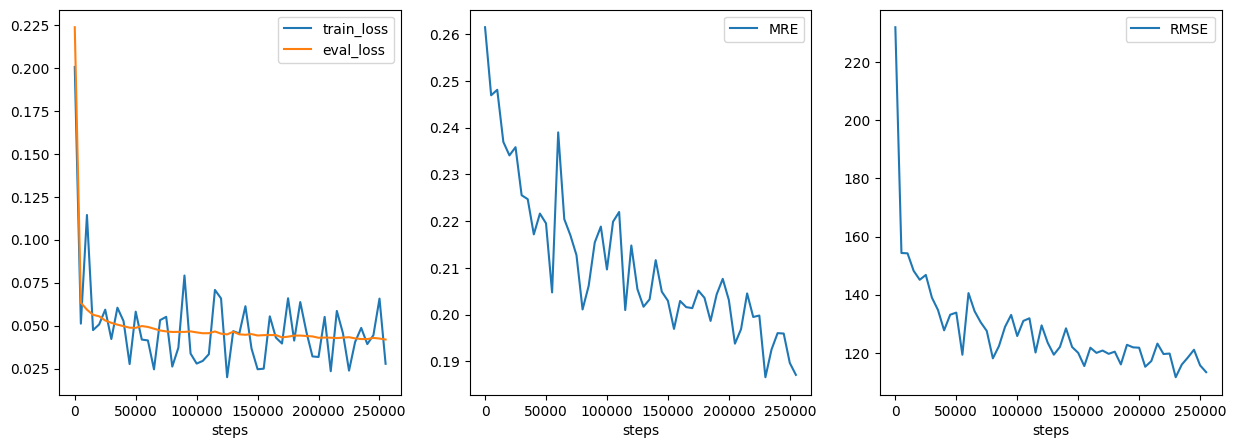

In [20]:
init_model_funcs = {
    ModelType.LSTM.name: init_LSTM_model,
    ModelType.RNN.name: init_RNN_model,
    ModelType.GRU.name: init_GRU_model,
    ModelType.MLPTestSubgraph.name: init_MLPTestSubgraph_model,
    ModelType.GCNSubgraph.name: init_GCNSubgraph_model,
}

# model_type = ModelType.MLPTestSubgraph
model_type = ModelType.LSTM
# model_type = ModelType.GRU
# model_type = ModelType.Transformer
conf: Config = train_configs[model_type.name]
init_model = init_model_funcs[model_type.name]
model = init_model()
model = model.to(conf.device)
single_train_loop(model_type, conf, preprocessed_train_ds,
                  preprocessed_eval_ds, model, compute_evaluate_metrics, to_device)

In [21]:
# init_model_funcs = {
#     ModelType.Transformer.name: init_Transformer_model,
#     ModelType.GCNSubgraph.name: init_GCNSubgraph_model,
#     ModelType.GRU.name: init_GRU_model,
#     ModelType.LSTM.name: init_LSTM_model,
#     ModelType.MLPTestSubgraph.name: init_MLPTestSubgraph_model,
#     ModelType.RNN.name: init_RNN_model,
# }

# model_type = ModelType.GCNSubgraph
# conf: Config = train_configs[model_type.name]
# init_model = init_model_funcs[model_type.name]

# model = init_model()
# model = model.to(conf.device)
# grid_search_loop(model_type,
#                  conf,
#                  preprocessed_train_ds,
#                  preprocessed_eval_ds,
#                  compute_evaluate_metrics,
#                  to_device,
#                  init_model,
#                  )